# UMAP

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from plantclef.utils import get_spark
from pyspark.sql import functions as F
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
display(spark)

In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/process/"
dct_emb_path = "training_cropped_resized_v2/dino_dct/data"

# Define the GCS path to the embedding files
dct_gcs_path = f"{gcs_path}/{dct_emb_path}"

# Read the Parquet file into a DataFrame
dct_df = spark.read.parquet(dct_gcs_path)

# Show the data
dct_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     dct_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|170e88ca9af457daa1038092479b251c61c64f7d.jpg|   1742956|[-20648.51, 2133.689, -2555.3125, 14820.57, 685...|
|c24a2d8646f5bc7112a39908bd2f6c45bf066a71.jpg|   1356834|[-25395.82, -12564.387, 24736.02, 20483.8, 2115...|
|e1f68e5f05618921969aee2575de20e537e6d66b.jpg|   1563754|[-26178.633, -7670.404, -22552.29, -6563.006, 8...|
|b0433cd6968b57d52e5c25dc45a28e674a25e61e.jpg|   1367432|[-23662.764, -6773.8213, -8283.518, 3769.6064, ...|
|96478a0fe20a41e755b0c8d798690f2c2b7c115f.jpg|   1389010|[-22182.172, -19444.006, 23355.23, 7042.8604, -...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

### UMAP plot

In [6]:
# Transformation
grouped_df = (
    dct_df.groupBy("species_id")
    .agg(F.count("species_id").alias("n"))
    .orderBy(F.col("n").desc())
)

# Action
grouped_df.show()

+----------+---+
|species_id|  n|
+----------+---+
|   1369068|823|
|   1360257|793|
|   1737559|770|
|   1741625|700|
|   1414366|674|
|   1743246|668|
|   1737669|662|
|   1363575|653|
|   1394359|653|
|   1359160|642|
|   1358610|638|
|   1356729|636|
|   1358500|634|
|   1356290|632|
|   1360607|630|
|   1400151|627|
|   1357416|626|
|   1394624|625|
|   1722433|625|
|   1359162|624|
+----------+---+
only showing top 20 rows



In [30]:
# Param
num_top_species = 5

# Get top species DF
top_species = [
    int(row["species_id"]) for row in grouped_df.limit(num_top_species).collect()
]
print(f"Top {num_top_species} species ids: {top_species}")

subset_df = dct_df.filter(F.col("species_id").isin(top_species)).select(
    ["species_id", "dct_embedding"]
)

subset_df.show(20)

Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]
+----------+--------------------+
|species_id|       dct_embedding|
+----------+--------------------+
|   1369068|[-36576.234, 1761...|
|   1369068|[-20043.7, 34196....|
|   1369068|[-35115.734, -150...|
|   1369068|[-26131.54, 23989...|
|   1360257|[-25168.602, 2493...|
|   1360257|[-26522.04, 11011...|
|   1360257|[-26688.137, 3025...|
|   1737559|[-19625.156, 1337...|
|   1737559|[-27562.814, 2753...|
|   1741625|[-23579.916, -304...|
|   1369068|[-24399.701, 1469...|
|   1360257|[-26066.172, 2210...|
|   1360257|[-26028.656, 2360...|
|   1414366|[-13801.959, -262...|
|   1741625|[-31693.318, -115...|
|   1741625|[-26885.82, 13652...|
|   1741625|[-35678.977, 4013...|
|   1737559|[-33084.67, 27640...|
|   1737559|[-34980.47, -300....|
|   1369068|[-30771.305, 1317...|
+----------+--------------------+
only showing top 20 rows



In [44]:
unique_species = pandas_df["species_id"].unique()
print("Unique Species IDs:", unique_species)
print("Number of Unique Species:", len(unique_species))

Unique Species IDs: [1369068 1360257 1737559 1741625 1414366]
Number of Unique Species: 5


In [41]:
from sklearn.preprocessing import StandardScaler

# Convert to Pandas DF
pandas_df = subset_df.toPandas()

# Extract features and labels
emb_df = np.stack(pandas_df["dct_embedding"].values)
scaled_emb = StandardScaler().fit_transform(emb_df)
labels = pandas_df["species_id"].tolist()

# UMAP reduction
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="euclidean", random_state=42)
embedding = reducer.fit_transform(emb_df)  # NumPy array with shape (n_samples, 2)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


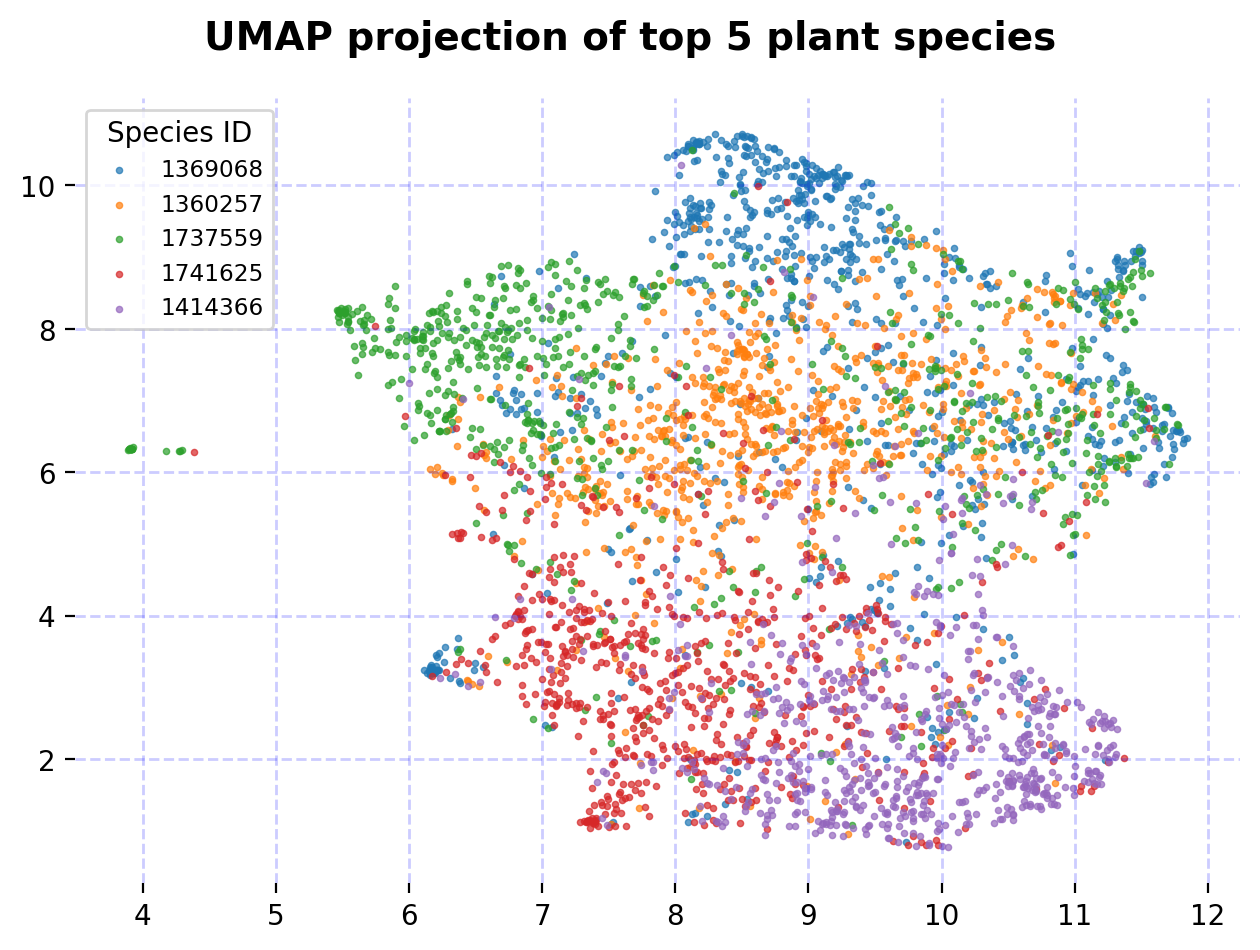

In [56]:
# Plot the data
fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
fig.suptitle("UMAP projection of top 5 plant species", fontsize=14, weight="bold")

# Create a scatter plot, color-coded by new species_idx
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
top_species_idx = pandas_df["species_id"].value_counts().nlargest(5).index
species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

# Map species IDs to colors for plotting
color_list = pandas_df["species_id"].map(species_to_color).tolist()

for species, color in species_to_color.items():
    # Select embeddings for the current species
    idx = pandas_df["species_id"] == species
    ax.scatter(
        embedding[idx, 0],
        embedding[idx, 1],
        c=color,
        # cmap="tab10",
        label=species,
        s=5,
        alpha=0.7,
        linewidth=0.5,
    )

ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
ax.legend(loc="best", title="Species ID", fontsize="small")
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
plt.show()